## 数字图像处理第二章

- Write a program for implementing image interpolation algorithms;

- Write a program for implementing Image Averaging;

- Show that 2-D transform with separable , symmetric kernels can be computed by
(1) computing 1-D transform along the individual rows (columns) of the input ,followed by (2) computing 1-D transforms along the columns (rows) of the result from step (1).




In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
img_path = "/content/drive/My Drive/数字图像处理/Image/x.jpg"
img = cv2.imread(img_path)
img = img[:, :, [2, 1, 0]]

(501, 500, 3)

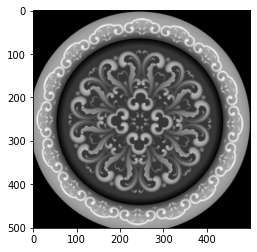

In [ ]:
plt.imshow(img)
img.shape

### Interpolation

- Nearest Interpolation

In [ ]:
new_h, new_w = img.shape[0]*2, img.shape[1]*2

In [ ]:
def nearest(img, new_h, new_w):
  h, w = img.shape
  out = np.zeros(shape=(new_h, new_w), dtype='uint8')
  for i in range(0, new_h):
    for j in range(0, new_w):
      nearest_h = (i / (new_h-1)) * (h-1)
      nearest_w = (j / (new_w-1)) * (w-1)

      nearest_h = round(nearest_h)
      nearest_w = round(nearest_w)

      out[i, j] = img[nearest_h][nearest_w]

  return out

In [ ]:
out = np.zeros(shape=(new_h, new_w, 3), dtype='uint8')
out[:, :, 0] = nearest(img[:, :, 0], new_h, new_w)
out[:, :, 1] = nearest(img[:, :, 1], new_h, new_w)
out[:, :, 2] = nearest(img[:, :, 2], new_h, new_w)

(1002, 1000, 3)

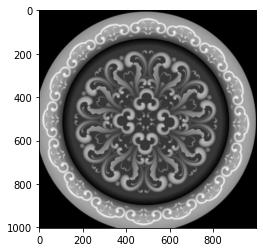

In [ ]:
plt.imshow(out)
out.shape

- Bi-Linear Interpolation

$f(x, 0)=f(0, 0) + x[f(1, 0) - f(0,0)]$

$f(x, 1)=f(0, 1) + x[f(1, 1) - f(0,1)]$

$f(x, y) = f(x, 0) + y[f(x, 1) - f(x, 0)]$


In [ ]:
def bi_linear(img, new_h, new_w):
  h, w = img.shape
  out = np.zeros(shape=(new_h, new_w), dtype='uint8')
  for i in range(0, new_h):
    for j in range(0, new_w):
      nearest_h = (i / (new_h-1)) * (h-1)
      nearest_w = (j / (new_w-1)) * (w-1)

      x0 = int(nearest_h)
      x1 = int(min(nearest_h + 1, h-1))

      y0 = int(nearest_w)
      y1 = int(min(nearest_w + 1, w-1))

      value1 = (img[x0, y1] - img[x0, y0]) * (nearest_w - y0) + img[x0, y0]
      value2 = (img[x1, y1] - img[x1, y0]) * (nearest_w - y0) + img[x1, y0]

      value = (value2 - value1) * (nearest_h - x0) + value1

      out[i, j] = int(value)

  return out

In [ ]:
out = np.zeros(shape=(new_h, new_w, 3), dtype='uint8')
out[:, :, 0] = bi_linear(img[:, :, 0], new_h, new_w)
out[:, :, 1] = bi_linear(img[:, :, 1], new_h, new_w)
out[:, :, 2] = bi_linear(img[:, :, 2], new_h, new_w)

(1002, 1000, 3)

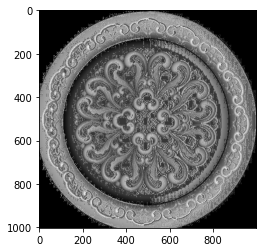

In [ ]:
plt.imshow(out)
out.shape

- Bicubic Interpolation

$s(x)=\begin{cases} 1-2|x|^2 + |x|^3, 0\leq|x|<1 \\
4-8|x| + 5|x|^2 -|x|^3, 1 \leq |x|<2 \\
0, |x|\geq 2 \end{cases}$


In [ ]:
def s(x):
  x = abs(x)
  if x < 1:
    return 1 - 2*x*x + x*x*x
  elif x < 2:
    return 4 - 8*x + 5*x*x - x*x*x
  else:
    return 0

In [ ]:
def bicubic(img, new_h, new_w):
  h, w = img.shape
  out = np.zeros(shape=(new_h, new_w), dtype='uint8')
  for i in range(0, new_h):
    for j in range(0, new_w):
      nearest_h = (i / (new_h-1)) * (h-1)
      nearest_w = (j / (new_w-1)) * (w-1)

      row_int = int(nearest_h)
      col_int = int(nearest_w)

      value = 0
      for m in range(-1, 3):
        for n in range(-1, 3):
          if (row_int + m) >= 0 and (col_int + n) >= 0 and (row_int + m) < h and (col_int + n) < m:
            k1 = s(nearest_h - m)
            k2 = s(nearest_w - n)
            value+= k1 * k2 * img[row_int+m, col_int+n]
      
      out[i, j] = int(value)

  return out

In [ ]:
out = np.zeros(shape=(new_h, new_w, 3), dtype='uint8')
out[:, :, 0] = bi_linear(img[:, :, 0], new_h, new_w)
out[:, :, 1] = bi_linear(img[:, :, 1], new_h, new_w)
out[:, :, 2] = bi_linear(img[:, :, 2], new_h, new_w)

(1002, 1000, 3)

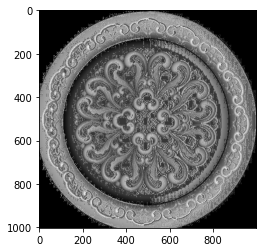

In [ ]:
plt.imshow(out)
out.shape

### Image Averaging

$g(x, y) = f(x, y) + noise$

$g^{-}(x, y) = \frac{1}{M}\sum_{i=1}^Mg_i(x, y)$

$M\to \infty, g^{-}(x, y) \to f(x, y)$

In [ ]:
def conv2d(img, filters):
  h, w = img.shape
  fh, fw = filters.shape

  # padding
  padding_h = int((fh - 1) / 2)
  padding_w = int((fw - 1) / 2)
  new_img = np.zeros(shape=(h + 2 * padding_h, w + 2 * padding_w))
  new_img[padding_h:h+padding_h, padding_w: w + padding_w] = img

  # conv2d
  out = np.zeros(shape=img.shape)

  for i in range(h):
    for j in range(w):
      out[i, j] = np.sum(new_img[i: i + fh, j : j + fw] * filters)
  
  return out

In [ ]:
def averag_img(img, filters=np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])):
  filters = filters / np.sum(filters)
  out = conv2d(img, filters)
  out = np.array(out, dtype='uint8')
  return out

In [ ]:
"""
给图片添加高斯噪声
"""
def add_gaussian_noise(image_in, noise_sigma):
  temp_image = np.float64(np.copy(image_in))
  h, w, _ = temp_image.shape
      # 标准正态分布*noise_sigma
  noise = np.random.randn(h, w) * noise_sigma
  
  noisy_image = np.zeros(temp_image.shape, np.float64)
  if len(temp_image.shape) == 2:
    noisy_image = temp_image + noise
  else:
    noisy_image[:,:,0] = temp_image[:,:,0] + noise
    noisy_image[:,:,1] = temp_image[:,:,1] + noise
    noisy_image[:,:,2] = temp_image[:,:,2] + noise
  return noisy_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


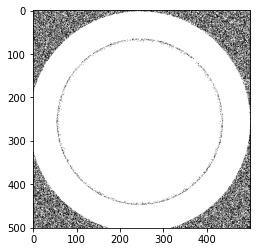

In [ ]:
noise_sigma = 10
noise_img = add_gaussian_noise(img,noise_sigma=noise_sigma)
plt.imshow(noise_img)

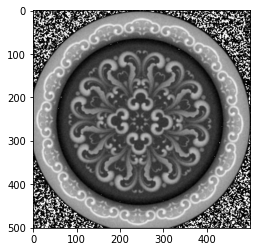

In [ ]:
out = np.zeros(shape=noise_img.shape, dtype='uint8')
out[:, :, 0] = averag_img(noise_img[:, :, 0])
out[:, :, 1] = averag_img(noise_img[:, :, 1])
out[:, :, 2] = averag_img(noise_img[:, :, 2])
plt.imshow(out)

- Show that 2-D transform with separable , symmetric kernels can be computed by (1) computing 1-D transform along the individual rows (columns) of the input ,followed by (2) computing 1-D transforms along the columns (rows) of the result from step (1).


\begin{equation}
\begin{aligned}
T(u, v)&=\sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x, y)r(x, y, u, v)
\\&=\sum_{x=0}^{M-1}r_1(x, u)\sum_{y=0}^{N-1}f(x, y)r_2(y, v)
\\&=\sum_{x=0}^{M-1}T(x, v)r_1(x, u)
\end{aligned}
\end{equation}

其中$T(x, v) = \sum_{y=0}^{N-1}f(x, y)r_2(y, v)=\sum_{y=0}^{N-1}f(x, y)r_1(y, v)$

可以看作首先沿$f(x, y)$的没一列进行$1-D$变换，得到$T(x, v) =\sum_{y=0}^{N-1}f(x, y)r_1(y, v)$

然后$T(x, v)$沿着每一行进行$1-D$变换，得到$T(u, v)=\sum_{x=0}^{M-1}T(x, v)r_1(x, u)$